In [36]:
import sys
sys.path.append('..')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read

from m_ff.configurations import carve_confs
from m_ff.models import TwoBodySingleSpeciesModel, ThreeBodySingleSpeciesModel, CombinedSingleSpeciesModel

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [91]:
# Parameters
directory = Path('data/BIP_300/')
r_cut = 8.4 # 8.4 to get the sensible energy files for BIP_300
sigma_2b = 0.2
sigma_3b = 1.2
noise = 0.003

# GP Parameters
ntr = 50
ntest = 50

# mapping
grid_start = 1.5
num_2b = 200
num_3b = 100


## Configurations

In [92]:
# Get configurations and forces from file
elementslist = [28]
confs = np.load(directory / 'confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory / 'forces_cut={:.2f}.npy'.format(r_cut))
energies = np.load(directory / 'energies_cut={:.2f}.npy'.format(r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

energies = np.repeat(energies, 19)
energies = energies - np.mean(energies)
# Separate into random testing and training dataset
# tr_confs, tr_forces, tr_energies = confs[ind_tot[:ntr]], forces[ind_tot[:ntr]], energies[ind_tot[:ntr]]
# tst_confs, tst_forces, tst_energies = confs[ind_tot[ntr:]], forces[ind_tot[ntr:]], energies[ind_tot[ntr:]]

# # Use fixed training and testing dataset
tr_confs, tr_forces, tr_energies = confs[0::20][:ntr], forces[0::20][:ntr],  energies[0::20][:ntr]
tst_confs, tst_forces, tst_energies = confs[0::20][-ntest - 1:-1], forces[0::20][-ntest - 1:-1], energies[0::20][-ntest - 1:-1]

## GP

In [93]:
# model_c = CombinedSingleSpeciesModel(elementslist[0], r_cut, sigma_2b, sigma_3b, r_cut / 10.0, r_cut / 10.0, noise)
# model_c = ThreeBodySingleSpeciesModel(elementslist[0], r_cut, sigma_3b, r_cut / 10.0, noise)
model_c = TwoBodySingleSpeciesModel(elementslist[0], r_cut, sigma_2b, r_cut / 10.0, noise)

INFO:m_ff.kernels.twobody:Started compilation of theano two body single species kernels
INFO:m_ff.kernels.twobody:Ended compilation of theano two body single species kernels


In [94]:
# model_c.fit(tr_confs, tr_forces)
# model_c.fit_energy(tr_confs, tr_energies)
model_c.fit_force_and_energy(tr_confs, tr_forces, tr_energies)

In [95]:
# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))
gp_energies = np.zeros(ntest)

for i in np.arange(ntest):
    gp_forces[i, :] = model_c.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_energies[i] = model_c.predict_energy(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
                
force_error = gp_forces - tst_forces
energy_error = gp_energies - tst_energies

MAEF = np.mean(np.sqrt(np.sum(np.square(force_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(force_error), axis=1)))

MAE = np.mean(np.abs(energy_error))
SMAE = np.std(np.abs(energy_error))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('MAEF on forces:  {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('MAE on energies: {:.4f} +- {:.4f}'.format(MAE, SMAE))

Testing GP
MAEF on forces:  0.2527 +- 0.2041
MAE on energies: 0.0939 +- 0.0650


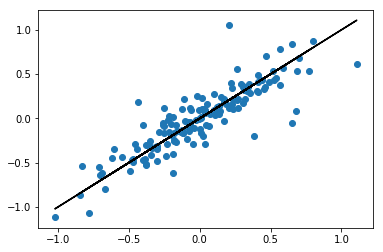

In [96]:
plt.scatter(tst_forces, gp_forces)
plt.plot(tst_forces, tst_forces, 'k-')
plt.show()

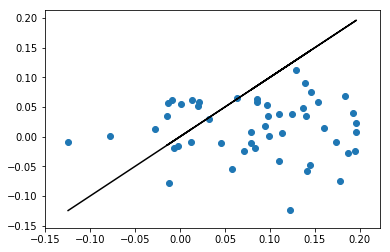

In [97]:
plt.scatter(tst_energies, gp_energies)
plt.plot(tst_energies, tst_energies, 'k-')
plt.show()

In [98]:
plt.matshow(np.abs(model_c.gp_2b.K))
# diag = np.diag(model_c.gp.energy_K)
# distance = np.sqrt(diag[:,None]+ diag[None,:] - 2*model_c.gp.energy_K)
# plt.matshow(distance)

plt.colorbar()
plt.show()

AttributeError: 'TwoBodySingleSpeciesModel' object has no attribute 'gp_2b'

In [ ]:
# plt.matshow(abs(model_c.gp.L_))
diag = np.diag(model_c.gp_3b.K)
distance = np.sqrt(diag[:,None]+ diag[None,:] - 2*model_c.gp_3b.K)
plt.matshow(distance)

plt.colorbar()
plt.show()

## Mapping

In [99]:
# model_c.build_grid(grid_start, num_2b, num_3b)
model_c.build_grid(grid_start, num_2b)

## Test Mapping on GP

In [166]:
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies

# calc = ThreeBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0], elementslist[0])])
calc = TwoBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0])], rep_alpha = 1.4)
# calc = CombinedSingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0])], model_c.grid[(elementslist[0], elementslist[0], elementslist[0])], \
#                              rep_alpha = 0.0)

map_forces = np.zeros((ntest,3))
map_energies = np.zeros(ntest)
gp_energies = np.zeros(ntest)
for i in np.arange(ntest):
    numatoms = len(tst_confs[i][:,:3])+1
#     atoms = Atoms('Ni19', positions = np.vstack(([0.0, 0.0, 0.0], tst_confs[i][:,:3])), cell = 21.0*np.eye(3), pbc = [0, 0, 0] )
    atoms = Atoms('Ni%i' %(numatoms), positions = np.vstack(([0.0, 0.0, 0.0], tst_confs[i][:,:3])), cell = 21.0*np.eye(3), pbc = [0, 0, 0] )
    atoms.set_calculator(calc)
    map_forces[i] = atoms.get_forces()[0]
    map_energies[i] = atoms.get_potential_energy(0)
    gp_energies[i] = model_c.predict_energy(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))

map_error = gp_forces - map_forces  
energy_error = gp_energies - map_energies
MAEF = np.mean(np.sqrt(np.sum(np.square(map_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(map_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))
# print(np.mean(np.sqrt(np.mean(np.square(map_forces), axis = 1))))
print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
#     print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


MAEF on forces: 0.0250 +- 0.0073


In [167]:
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies

# calc = CombinedSingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0])], model_c.grid[(elementslist[0], elementslist[0], elementslist[0])], \
#                              rep_alpha = 0.0)
# calc = ThreeBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0], elementslist[0])])
# calc = TwoBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0])], rep_alpha = 1.3)

reps = 5
map_error = np.zeros((reps**2, 3))
for i in np.arange(reps):
    for j in np.arange(reps):
        for k in np.arange(1):
            for l in np.arange(1):
                conf = np.asarray([[0.0, 0.0, 0.0, 28, 28],[1.5+i*0.1, 0.0, 0.0, 28, 28], [0.0, 1.5+j*0.1, 0.0, 28, 28]])
                atoms = Atoms('Ni3', positions = conf[:,:3], cell = 21.0*np.eye(3), pbc = [0, 0, 0] )
                atoms.set_calculator(calc)
                map_forces = atoms.get_forces()
                small_gp_forces = model_c.predict(np.reshape(conf[1:], (1,2,5)))
                print(map_forces[0], small_gp_forces)
#                 print(atoms.get_potential_energy(0), model_c.predict_energy(np.reshape(conf[1:], (1,2,5))))
                map_error[i*reps+j]= small_gp_forces - map_forces[0]

    #             MAEF = np.mean(np.sqrt(np.sum(np.square(map_error), axis=1)))
    #             SMAEF = np.std(np.sqrt(np.sum(np.square(map_error), axis=1)))

    #             MF = np.mean(np.linalg.norm(tst_forces, axis=1))
            #     print(small_gp_forces)
            #     print(map_forces[0])
    #             print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
            #     print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))
MAEF = np.mean(np.sqrt(np.sum(np.square(map_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(map_error), axis=1)))  
print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


[-0.59473985 -0.59473985  0.        ] [[2.92390599 2.92390599 0.        ]]
[-0.59473985  3.56692117  0.        ] [[2.92390599 5.07818232 0.        ]]
[-0.59473985  3.75738047  0.        ] [[2.92390599 4.44420495 0.        ]]
[-0.59473985 -1.04102805  0.        ] [[ 2.92390599 -0.71645566  0.        ]]
[-0.59473985 -5.80235347  0.        ] [[ 2.92390599 -5.64026764  0.        ]]
[ 3.56692117 -0.59473985  0.        ] [[5.07818232 2.92390599 0.        ]]
[3.56692117 3.56692117 0.        ] [[5.07818232 5.07818232 0.        ]]
[3.56692117 3.75738047 0.        ] [[5.07818232 4.44420495 0.        ]]
[ 3.56692117 -1.04102805  0.        ] [[ 5.07818232 -0.71645566  0.        ]]
[ 3.56692117 -5.80235347  0.        ] [[ 5.07818232 -5.64026764  0.        ]]
[ 3.75738047 -0.59473985  0.        ] [[4.44420495 2.92390599 0.        ]]
[3.75738047 3.56692117 0.        ] [[4.44420495 5.07818232 0.        ]]
[3.75738047 3.75738047 0.        ] [[4.44420495 4.44420495 0.        ]]
[ 3.75738047 -1.04102805 

In [168]:
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies
# calc = CombinedSingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0])], model_c.grid[(elementslist[0], elementslist[0], elementslist[0])], \
#                              rep_alpha = 1.5)
# calc = ThreeBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0], elementslist[0])])

npoints_grid = 200
potential = np.zeros(npoints_grid)
force = np.zeros(npoints_grid)
gp_potential = np.zeros(npoints_grid)
gp_force = np.zeros((npoints_grid, 3))
for i in np.arange(npoints_grid):
    conf = np.asarray([[0.0, 0.0, 0.0, 28, 28],[1.5+i*(7/npoints_grid), 0.0, 0.0, 28, 28]])
    atoms = Atoms('Ni2', positions = conf[:,:3], cell = 21.0*np.eye(3), pbc = [0, 0, 0] )
    atoms.set_calculator(calc)
    potential[i] = atoms.get_potential_energy()
    force[i] = atoms.get_forces()[0][0]
    gp_potential[i] = model_c.predict_energy(np.reshape(conf[1], (1, 1, 5)))
    gp_force[i] = model_c.predict(np.reshape(conf[1], (1, 1, 5)))

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


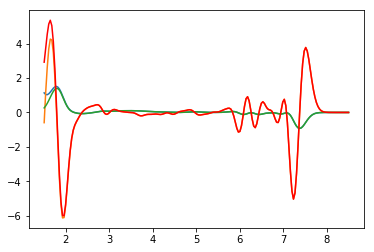

In [169]:
plt.plot(np.linspace(1.5, 8.5, npoints_grid), potential)
plt.plot(np.linspace(1.5, 8.5, npoints_grid), force)
plt.plot(np.linspace(1.5, 8.5, npoints_grid), gp_potential)
plt.plot(np.linspace(1.5, 8.5, npoints_grid), gp_force[:,0], 'r')
plt.show()

## Test mapping on traj

In [171]:
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies
# calc = CombinedSingleSpecies(r_cut, model_c.grid[(28, 28)], model_c.grid[(28, 28, 28)], rep_alpha = 1.2)
# calc = TwoBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0])], rep_alpha = 0.0)
# calc = ThreeBodySingleSpecies(r_cut, model_c.grid[(elementslist[0], elementslist[0], elementslist[0])])

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 10))
# for atoms in traj:
#     atoms.set_cell(21.0*np.identity(3))
#     atoms.set_calculator(calc)

#     #rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
#     #print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))
#     print(atoms.get_forces())


## Run simple dynamics

In [172]:
# Global Variables Definition
gamma = 0.001
temp = 200 #K
dt = 1.0  # fs
steps = 10000
t = steps * dt * 10 ** (-3)  # time in ps

In [173]:
atoms = traj[1]
atoms.set_positions(traj[1].get_positions())
atoms.set_pbc(False)
atoms.set_cell([(21, 0, 0), (0, 21, 0), (0, 0, 21)])
atoms.set_calculator(calc)

In [174]:
# from ase.build import bulk, stack
# atoms = bulk('Fe', 'bcc', a=2.856, cubic=True)
# atoms = stack(atoms, atoms, axis=0)
# atoms = stack(atoms, atoms, axis=1)
# atoms = stack(atoms, atoms, axis=2)
# atoms = stack(atoms, atoms, axis=0)
# atoms = stack(atoms, atoms, axis=1)
# atoms = stack(atoms, atoms, axis=2)

# del atoms[0]
# atoms.set_calculator(calc)
# len(atoms)

In [175]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units

Stationary(atoms)
ZeroRotation(atoms)
dyn = VelocityVerlet(atoms, dt * units.fs)
MaxwellBoltzmannDistribution(atoms, 2.0 * temp * units.kB)

In [176]:
def printenergy(a=atoms):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
def savexyz(a=atoms):
    this_traj = open(traj_filename, "a")
    extxyz.write_extxyz(this_traj, [atoms])
    
def printforces(a=atoms):
    forces = a.get_forces()
    print(forces)

In [177]:
import scipy as sp
pos = atoms.get_positions()
dist = np.reshape(sp.spatial.distance.cdist(pos, pos), len(pos)**2)
from ase.io import extxyz
traj_filename = "example.xyz"

In [178]:
# this_traj = open(traj_filename, "w")
# dyn.attach(savexyz, interval=50)
dyn.attach(printenergy, interval=10)
dyn.run(10000)

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


Energy per atom: Epot = -0.015eV  Ekin = 0.041eV (T=319K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=227K)  Etot = 0.027eV
Energy per atom: Epot = 0.007eV  Ekin = 0.020eV (T=151K)  Etot = 0.027eV
Energy per atom: Epot = 0.010eV  Ekin = 0.017eV (T=131K)  Etot = 0.027eV
Energy per atom: Epot = 0.007eV  Ekin = 0.020eV (T=154K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.023eV (T=181K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=189K)  Etot = 0.026eV
Energy per atom: Epot = 0.005eV  Ekin = 0.021eV (T=165K)  Etot = 0.026eV
Energy per atom: Epot = 0.011eV  Ekin = 0.015eV (T=117K)  Etot = 0.026eV
Energy per atom: Epot = 0.012eV  Ekin = 0.014eV (T=109K)  Etot = 0.026eV
Energy per atom: Epot = 0.005eV  Ekin = 0.021eV (T=160K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=219K)  Etot = 0.026eV
Energy per atom: Epot = -0.007eV  Ekin = 0.033eV (T=253K)  Etot = 0.026eV
Energy per atom: Epot = -0.009eV  Ekin = 0.035e

Energy per atom: Epot = -0.001eV  Ekin = 0.026eV (T=204K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.028eV (T=220K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.030eV (T=234K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.031eV (T=240K)  Etot = 0.026eV
Energy per atom: Epot = -0.004eV  Ekin = 0.030eV (T=229K)  Etot = 0.026eV
Energy per atom: Epot = -0.001eV  Ekin = 0.027eV (T=207K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.025eV (T=190K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=185K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=188K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.025eV (T=190K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.023eV (T=180K)  Etot = 0.026eV
Energy per atom: Epot = 0.006eV  Ekin = 0.020eV (T=153K)  Etot = 0.026eV
Energy per atom: Epot = 0.008eV  Ekin = 0.018eV (T=135K)  Etot = 0.026eV
Energy per atom: Epot = 0.007eV  Ekin = 0.019

Energy per atom: Epot = 0.000eV  Ekin = 0.026eV (T=201K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=195K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=195K)  Etot = 0.026eV
Energy per atom: Epot = -0.001eV  Ekin = 0.027eV (T=206K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=215K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=221K)  Etot = 0.026eV
Energy per atom: Epot = -0.004eV  Ekin = 0.030eV (T=229K)  Etot = 0.026eV
Energy per atom: Epot = -0.004eV  Ekin = 0.030eV (T=229K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=224K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=217K)  Etot = 0.026eV
Energy per atom: Epot = -0.000eV  Ekin = 0.026eV (T=202K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=193K)  Etot = 0.026eV
Energy per atom: Epot = 0.000eV  Ekin = 0.026eV (T=199K)  Etot = 0.026eV
Energy per atom: Epot = 0.000eV  Ekin = 0.0

Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=227K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.030eV (T=236K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=226K)  Etot = 0.026eV
Energy per atom: Epot = -0.001eV  Ekin = 0.027eV (T=206K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=186K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.023eV (T=175K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.023eV (T=176K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=187K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=193K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.023eV (T=181K)  Etot = 0.025eV
Energy per atom: Epot = 0.004eV  Ekin = 0.021eV (T=165K)  Etot = 0.025eV
Energy per atom: Epot = 0.005eV  Ekin = 0.021eV (T=162K)  Etot = 0.025eV
Energy per atom: Epot = 0.004eV  Ekin = 0.021eV (T=164K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.022eV

Energy per atom: Epot = -0.001eV  Ekin = 0.028eV (T=213K)  Etot = 0.026eV
Energy per atom: Epot = -0.004eV  Ekin = 0.030eV (T=229K)  Etot = 0.026eV
Energy per atom: Epot = -0.004eV  Ekin = 0.030eV (T=231K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=216K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=186K)  Etot = 0.026eV
Energy per atom: Epot = 0.006eV  Ekin = 0.020eV (T=157K)  Etot = 0.026eV
Energy per atom: Epot = 0.007eV  Ekin = 0.020eV (T=151K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.023eV (T=178K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=223K)  Etot = 0.026eV
Energy per atom: Epot = -0.008eV  Ekin = 0.034eV (T=262K)  Etot = 0.026eV
Energy per atom: Epot = -0.009eV  Ekin = 0.035eV (T=271K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.031eV (T=241K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=190K)  Etot = 0.026eV
Energy per atom: Epot = 0.007eV  Ekin = 0.0

Energy per atom: Epot = 0.001eV  Ekin = 0.026eV (T=199K)  Etot = 0.026eV
Energy per atom: Epot = 0.004eV  Ekin = 0.023eV (T=174K)  Etot = 0.026eV
Energy per atom: Epot = 0.006eV  Ekin = 0.020eV (T=157K)  Etot = 0.026eV
Energy per atom: Epot = 0.004eV  Ekin = 0.023eV (T=174K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.029eV (T=222K)  Etot = 0.026eV
Energy per atom: Epot = -0.007eV  Ekin = 0.033eV (T=257K)  Etot = 0.026eV
Energy per atom: Epot = -0.007eV  Ekin = 0.034eV (T=259K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.031eV (T=241K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=216K)  Etot = 0.026eV
Energy per atom: Epot = 0.000eV  Ekin = 0.025eV (T=197K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=190K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=190K)  Etot = 0.026eV
Energy per atom: Epot = 0.002eV  Ekin = 0.024eV (T=183K)  Etot = 0.025eV
Energy per atom: Epot = 0.005eV  Ekin = 0.021e

Energy per atom: Epot = -0.001eV  Ekin = 0.026eV (T=204K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=219K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=228K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.028eV (T=214K)  Etot = 0.026eV
Energy per atom: Epot = 0.000eV  Ekin = 0.026eV (T=203K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.026eV (T=199K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=194K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.024eV (T=184K)  Etot = 0.026eV
Energy per atom: Epot = 0.004eV  Ekin = 0.023eV (T=176K)  Etot = 0.026eV
Energy per atom: Epot = 0.004eV  Ekin = 0.023eV (T=175K)  Etot = 0.026eV
Energy per atom: Epot = 0.004eV  Ekin = 0.022eV (T=173K)  Etot = 0.026eV
Energy per atom: Epot = 0.005eV  Ekin = 0.021eV (T=163K)  Etot = 0.026eV
Energy per atom: Epot = 0.006eV  Ekin = 0.020eV (T=154K)  Etot = 0.026eV
Energy per atom: Epot = 0.005eV  Ekin = 0.021eV

Energy per atom: Epot = -0.002eV  Ekin = 0.029eV (T=221K)  Etot = 0.026eV
Energy per atom: Epot = -0.001eV  Ekin = 0.028eV (T=214K)  Etot = 0.026eV
Energy per atom: Epot = 0.000eV  Ekin = 0.026eV (T=203K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=196K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=196K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=194K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=192K)  Etot = 0.026eV
Energy per atom: Epot = 0.000eV  Ekin = 0.026eV (T=200K)  Etot = 0.026eV
Energy per atom: Epot = -0.001eV  Ekin = 0.027eV (T=210K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0.027eV (T=213K)  Etot = 0.026eV
Energy per atom: Epot = -0.001eV  Ekin = 0.027eV (T=205K)  Etot = 0.026eV
Energy per atom: Epot = 0.001eV  Ekin = 0.025eV (T=191K)  Etot = 0.026eV
Energy per atom: Epot = 0.003eV  Ekin = 0.023eV (T=176K)  Etot = 0.026eV
Energy per atom: Epot = 0.004eV  Ekin = 0.022e

Energy per atom: Epot = -0.001eV  Ekin = 0.027eV (T=207K)  Etot = 0.025eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=223K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.030eV (T=234K)  Etot = 0.026eV
Energy per atom: Epot = -0.005eV  Ekin = 0.031eV (T=237K)  Etot = 0.026eV
Energy per atom: Epot = -0.003eV  Ekin = 0.030eV (T=228K)  Etot = 0.026eV
Energy per atom: Epot = -0.000eV  Ekin = 0.027eV (T=206K)  Etot = 0.026eV
Energy per atom: Epot = 0.005eV  Ekin = 0.022eV (T=169K)  Etot = 0.027eV
Energy per atom: Epot = 0.009eV  Ekin = 0.018eV (T=138K)  Etot = 0.027eV
Energy per atom: Epot = 0.008eV  Ekin = 0.018eV (T=142K)  Etot = 0.027eV
Energy per atom: Epot = 0.003eV  Ekin = 0.024eV (T=182K)  Etot = 0.027eV
Energy per atom: Epot = -0.003eV  Ekin = 0.029eV (T=226K)  Etot = 0.026eV
Energy per atom: Epot = -0.007eV  Ekin = 0.033eV (T=253K)  Etot = 0.026eV
Energy per atom: Epot = -0.007eV  Ekin = 0.032eV (T=251K)  Etot = 0.026eV
Energy per atom: Epot = -0.002eV  Ekin = 0

In [ ]:
a = np.linspace(1.0, 2.0, 21)
b = (1.2/a)**12
plt.plot(a,b)
plt.show()

In [26]:
from ase.calculators.eam import EAM

from ase.build import bulk

# test to generate an EAM potential file using a simplified
# approximation to the Mishin potential Al99.eam.alloy data

from scipy.interpolate import InterpolatedUnivariateSpline as spline

cutoff = 10.0

n = 21
rs = np.arange(0, n) * (cutoff / n)
rhos = np.arange(0, 2, 2. / n)

# generated from
# mishin = EAM(potential='../potentials/Al99.eam.alloy')
# m_density = mishin.electron_density[0](rs)
# m_embedded = mishin.embedded_energy[0](rhos)
# m_phi = mishin.phi[0,0](rs)

m_density = np.array([2.78589606e-01, 2.02694937e-01, 1.45334053e-01,
                      1.06069912e-01, 8.42517168e-02, 7.65140344e-02,
                      7.76263116e-02, 8.23214224e-02, 8.53322309e-02,
                      8.13915861e-02, 6.59095390e-02, 4.28915711e-02,
                      2.27910928e-02, 1.13713167e-02, 6.05020311e-03,
                      3.65836583e-03, 2.60587564e-03, 2.06750708e-03,
                      1.48749693e-03, 7.40019174e-04, 6.21225205e-05])

m_embedded = np.array([1.04222211e-10, -1.04142633e+00, -1.60359806e+00,
                       -1.89287637e+00, -2.09490167e+00, -2.26456628e+00,
                       -2.40590322e+00, -2.52245359e+00, -2.61385603e+00,
                       -2.67744693e+00, -2.71053295e+00, -2.71110418e+00,
                       -2.69287013e+00, -2.68464527e+00, -2.69204083e+00,
                       -2.68976209e+00, -2.66001244e+00, -2.60122024e+00,
                       -2.51338548e+00, -2.39650817e+00, -2.25058831e+00])

m_phi = np.array([6.27032242e+01, 3.49638589e+01, 1.79007014e+01,
                  8.69001383e+00, 4.51545250e+00, 2.83260884e+00,
                  1.93216616e+00, 1.06795515e+00, 3.37740836e-01,
                  1.61087890e-02, -6.20816372e-02, -6.51314297e-02,
                  -5.35210341e-02, -5.20950200e-02, -5.51709524e-02,
                  -4.89093894e-02, -3.28051688e-02, -1.13738785e-02,
                  2.33833655e-03, 4.19132033e-03, 1.68600692e-04])

m_densityf = spline(rs, m_density)
m_embeddedf = spline(rhos, m_embedded)
m_phif = spline(rs, m_phi)

mishin_approx = EAM(elements=['Ni'], embedded_energy=np.array([m_embeddedf]),
                    electron_density=np.array([m_densityf]),
                    phi=np.array([[m_phif]]), cutoff=cutoff, form='alloy',
                    # the following terms are only required to write out a file
                    Z=[13], nr=n, nrho=n, dr=cutoff / n, drho=2. / n,
                    lattice=['fcc'], mass=[58.692], a=[2.58])

atoms.set_calculator(mishin_approx)

In [32]:
from ase.calculators import morse
pot = morse.MorsePotential
atoms.set_calculator(pot)


In [33]:
dyn.run(1000)

AttributeError: 'Atoms' object has no attribute 'get_property'

## Pairwise potential test

In [3]:
model_2b = TwoBodySingleSpeciesModel(elementslist[0], r_cut, sigma_2b, r_cut / 10.0, noise)
model_2b.fit(tr_confs, tr_forces)

NameError: name 'TwoBodySingleSpeciesModel' is not defined

In [51]:
# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i, :] = model_2b.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

Testing GP
MAEF on forces: 0.1404 +- 0.0750
Relative MAEF on forces: 0.1943 +- 0.1038


In [52]:
grid_2b = model_2b.build_grid(grid_start, num_2b)


In [53]:
calc = TwoBodySingleSpecies(r_cut, grid_c_2b)
atoms.set_calculator(calc)

In [54]:
dyn.run(steps)

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


In [17]:
dist = 2+np.arange(7)
norm = np.ones((7,3))


array([1.58381760e-02, 8.13802083e-05, 1.93337110e-06, 1.06288200e-07,
       9.93410746e-09, 1.33912337e-09, 2.36007214e-10])

In [18]:
np.power(1.5/dist, 12)/dist

array([1.58381760e-02, 8.13802083e-05, 1.93337110e-06, 1.06288200e-07,
       9.93410746e-09, 1.33912337e-09, 2.36007214e-10])